In [1]:
# %matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# feel free to modify, for example, change the context to "notebook"
sns.set_theme(context="talk", style="whitegrid",
              palette="colorblind", color_codes=True,
              rc={"figure.figsize": [10, 6]})

Portfolio Optmization using  Riskfolio

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import quantstats as qs
from scipy.stats import norm
import riskfolio as rp
import cvxpy as cp
from datetime import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.4%}'.format


In [5]:
assets = ['ADBE', 'AMD','AMZN','AAPL','GOOG','META','MSFT', 'NFLX','NVDA','TSLA']

In [6]:
assets.sort()

In [7]:
start_date= '2019-07-05'
end_date= '2023-07-05'

In [8]:
n_assets=len(assets)

In [9]:
prices_df=pd.DataFrame()

prices_df= yf.download(assets, start=start_date, end=end_date)

[*********************100%***********************]  10 of 10 completed


In [10]:
prices_df.head().dropna()

Adj Close                                                 
                 AAPL        ADBE        AMD        AMZN       GOOG   
Date                                                                  
2019-07-05 4953.7132% 30398.0011% 3150.0000%  9714.5500% 5657.9498%  \
2019-07-08 4851.5987% 30292.0013% 3204.0001%  9761.5997% 5581.7501%   
2019-07-09 4881.1901% 30420.0012% 3315.0002%  9941.5001% 5624.1501%   
2019-07-10 4929.4586% 30698.0011% 3379.0001% 10087.0499% 5702.3998%   
2019-07-11 4893.5608% 30760.0006% 3306.0001% 10005.3497% 5721.0499%   

                                                                      ...   
                  META        MSFT        NFLX       NVDA       TSLA  ...   
Date                                                                  ...   
2019-07-05 19639.9994% 13173.6084% 38054.9988% 3983.9508% 1554.0000%  ...  \
2019-07-08 19575.9995% 13163.9954% 37616.0004% 3908.8619% 1535.6000%  ...   
2019-07-09 19921.0007% 13115.9363% 37992.9993% 3911.3483% 1533.7333%  ...   
2019-07-10 20272.9996% 13249.5361% 38100.0000% 3979.7245% 1592.8000%  ...   
2019-07-11 20122.9996% 13302.4033% 37950.0000% 4134.3788% 1590.6667%  ...   

               Volume                                                    
                 AAPL     ADBE       AMD      AMZN      GOOG      META   
Date                                                                     
2019-07-05   69062000  2872700  34011900  52568000  25286000  11164100  \
2019-07-08  101354400  1909200  49689400  57668000  24728000   9723900   
2019-07-09   82312000  1644300  61419800  86914000  26608000  14698600   
2019-07-10   71588400  1954100  60388400  98638000  24190000  20571700   
2019-07-11   80767200  1951500  63081800  86356000  23910000  13678500   

                                                    
                MSFT     NFLX      NVDA       TSLA  
Date                                                
2019-07-05  18141100  3732200  39655200  105985500  
2019-07-08  16779700  3113400  32978800   88207500  
2019-07-09  19953100  6932800  34286000   92862000  
2019-07-10  24204400  5878800  45207600  137185500  
2019-07-11  22327900  4336300  68256000  112716000  

[5 rows x 60 columns]

In [11]:
prices_df.tail().dropna()

Adj Close                                                   
                  AAPL        ADBE         AMD        AMZN        GOOG   
Date                                                                     
2023-06-27 18805.9998% 48926.9989% 11038.9999% 12917.9993% 11901.0002%  \
2023-06-28 18925.0000% 48242.9993% 11016.9998% 12903.9993% 12108.0002%   
2023-06-29 18958.9996% 48376.9989% 11123.9998% 12790.0002% 12001.0002%   
2023-06-30 19397.0001% 48898.9990% 11391.0004% 13036.0001% 12097.0001%   
2023-07-03 19246.0007% 48520.9991% 11582.0000% 13022.0001% 12055.9998%   

                                                                        ...   
                  META        MSFT        NFLX        NVDA        TSLA  ...   
Date                                                                    ...   
2023-06-27 28704.9988% 33457.0007% 41707.9987% 41876.0010% 25021.0007%  ...  \
2023-06-28 28529.0009% 33585.0006% 42983.9996% 41117.0013% 25623.9990%  ...   
2023-06-29 28152.9999% 33504.9988% 42823.9990% 40822.0001% 25750.0000%  ...   
2023-06-30 28698.0011% 34054.0009% 44048.9990% 42301.9989% 26176.9989%  ...   
2023-07-03 28601.9989% 33798.9990% 44144.0002% 42413.0005% 27982.0007%  ...   

              Volume                                                    
                AAPL     ADBE       AMD      AMZN      GOOG      META   
Date                                                                    
2023-06-27  50730800  2691700  59381600  46801000  27221700  26108300  \
2023-06-28  51216800  3229200  67534100  52149500  19753100  16722100   
2023-06-29  46347300  1905400  58347200  40761000  18517500  15395700   
2023-06-30  85069600  3095900  53331900  54310500  23865800  19676000   
2023-07-03  31458200  1491000  31860000  28264800  13888300   8629300   

                                                    
                MSFT     NFLX      NVDA       TSLA  
Date                                                
2023-06-27  24354100  4818100  46217500  164968200  
2023-06-28  20259500  8811300  58263900  159770800  
2023-06-29  16997000  4932300  38051400  131283400  
2023-06-30  26823800  7342000  50053400  112267600  
2023-07-03  12508700  3733200  19820900  119685900  

[5 rows x 60 columns]

In [12]:
prices_df["Adj Close"].head().dropna()

AAPL        ADBE        AMD        AMZN       GOOG   
Date                                                                  
2019-07-05 4953.7132% 30398.0011% 3150.0000%  9714.5500% 5657.9498%  \
2019-07-08 4851.5987% 30292.0013% 3204.0001%  9761.5997% 5581.7501%   
2019-07-09 4881.1901% 30420.0012% 3315.0002%  9941.5001% 5624.1501%   
2019-07-10 4929.4586% 30698.0011% 3379.0001% 10087.0499% 5702.3998%   
2019-07-11 4893.5608% 30760.0006% 3306.0001% 10005.3497% 5721.0499%   

                  META        MSFT        NFLX       NVDA       TSLA  
Date                                                                  
2019-07-05 19639.9994% 13173.6084% 38054.9988% 3983.9508% 1554.0000%  
2019-07-08 19575.9995% 13163.9954% 37616.0004% 3908.8619% 1535.6000%  
2019-07-09 19921.0007% 13115.9363% 37992.9993% 3911.3483% 1533.7333%  
2019-07-10 20272.9996% 13249.5361% 38100.0000% 3979.7245% 1592.8000%  
2019-07-11 20122.9996% 13302.4033% 37950.0000% 4134.3788% 1590.6667%

In [13]:
import cufflinks as cf
from plotly.offline import iplot, init_notebook_mode
import plotly.express as px
import pandas_bokeh
cf.go_offline()
pandas_bokeh.output_notebook()

Loading BokehJS ...

In [14]:
prices_df['Adj Close'].iplot()

In [15]:
returns= prices_df['Adj Close'].pct_change().dropna()

In [16]:
returns

AAPL     ADBE      AMD     AMZN     GOOG     META     MSFT   
Date                                                                        
2019-07-08 -2.0614% -0.3487%  1.7143%  0.4843% -1.3468% -0.3259% -0.0730%  \
2019-07-09  0.6099%  0.4226%  3.4644%  1.8429%  0.7596%  1.7624% -0.3651%   
2019-07-10  0.9889%  0.9139%  1.9306%  1.4641%  1.3913%  1.7670%  1.0186%   
2019-07-11 -0.7282%  0.2020% -2.1604% -0.8100%  0.3271% -0.7399%  0.3990%   
2019-07-12  0.7683%  0.5917%  0.4537%  0.4962%  0.0603%  1.8089%  0.3612%   
...             ...      ...      ...      ...      ...      ...      ...   
2023-06-27  1.5059%  2.0354%  2.6788%  1.4529% -0.0672%  3.0811%  1.8168%   
2023-06-28  0.6328% -1.3980% -0.1993% -0.1084%  1.7393% -0.6131%  0.3826%   
2023-06-29  0.1797%  0.2778%  0.9712% -0.8834% -0.8837% -1.3180% -0.2382%   
2023-06-30  2.3103%  1.0790%  2.4002%  1.9234%  0.7999%  1.9359%  1.6386%   
2023-07-03 -0.7785% -0.7730%  1.6768% -0.1074% -0.3389% -0.3345% -0.7488%   

               NFLX     NVDA     TSLA  
Date                                   
2019-07-08 -1.1536% -1.8848% -1.1840%  
2019-07-09  1.0022%  0.0636% -0.1216%  
2019-07-10  0.2816%  1.7481%  3.8512%  
2019-07-11 -0.3937%  3.8861% -0.1339%  
2019-07-12 -1.6469%  0.7998%  2.7158%  
...             ...      ...      ...  
2023-06-27  0.2741%  3.0616%  3.8000%  
2023-06-28  3.0594% -1.8125%  2.4100%  
2023-06-29 -0.3722% -0.7175%  0.4917%  
2023-06-30  2.8605%  3.6255%  1.6582%  
2023-07-03  0.2157%  0.2624%  6.8954%  

[1005 rows x 10 columns]

In [17]:
returns.iplot()

In [18]:
returns.describe()

AAPL         ADBE          AMD         AMZN         GOOG   
count 100500.0000% 100500.0000% 100500.0000% 100500.0000% 100500.0000%  \
mean       0.1579%      0.0768%      0.1871%      0.0559%      0.0969%   
std        2.1349%      2.4543%      3.3995%      2.3137%      2.0817%   
min      -12.8647%    -16.7932%    -14.6390%    -14.0494%    -11.1008%   
25%       -0.8826%     -1.0961%     -1.7264%     -1.1558%     -0.8845%   
50%        0.1255%      0.1521%      0.0481%      0.0554%      0.1068%   
75%        1.3478%      1.3367%      2.0601%      1.2222%      1.1168%   
max       11.9808%     17.7193%     16.5016%     13.5359%     10.4485%   

              META         MSFT         NFLX         NVDA         TSLA  
count 100500.0000% 100500.0000% 100500.0000% 100500.0000% 100500.0000%  
mean       0.0809%      0.1146%      0.0632%      0.2933%      0.3804%  
std        2.9216%      2.0390%      3.0484%      3.4140%      4.3009%  
min      -26.3901%    -14.7390%    -35.1166%    -18.4521%    -21.0628%  
25%       -1.2062%     -0.8974%     -1.4110%     -1.5469%     -1.7787%  
50%        0.0701%      0.0785%      0.0422%      0.3054%      0.2759%  
75%        1.4684%      1.1784%      1.4825%      2.1630%      2.4651%  
max       23.2824%     14.2169%     16.8543%     24.3696%     19.8949%

In [19]:
port=rp.Portfolio(returns=returns)

In [20]:
method_mu='hist'
method_cov='hist'
hist= True
model='Classic'
rm='MV'
obj='Sharpe'
rf=0
l=0

In [21]:
port.assets_stats(method_mu='hist', method_cov='hist', d=0.94)

In [22]:
w_rp=port.rp_optimization(model="Classic", rm="MV", hist=True, rf=0, b=None)

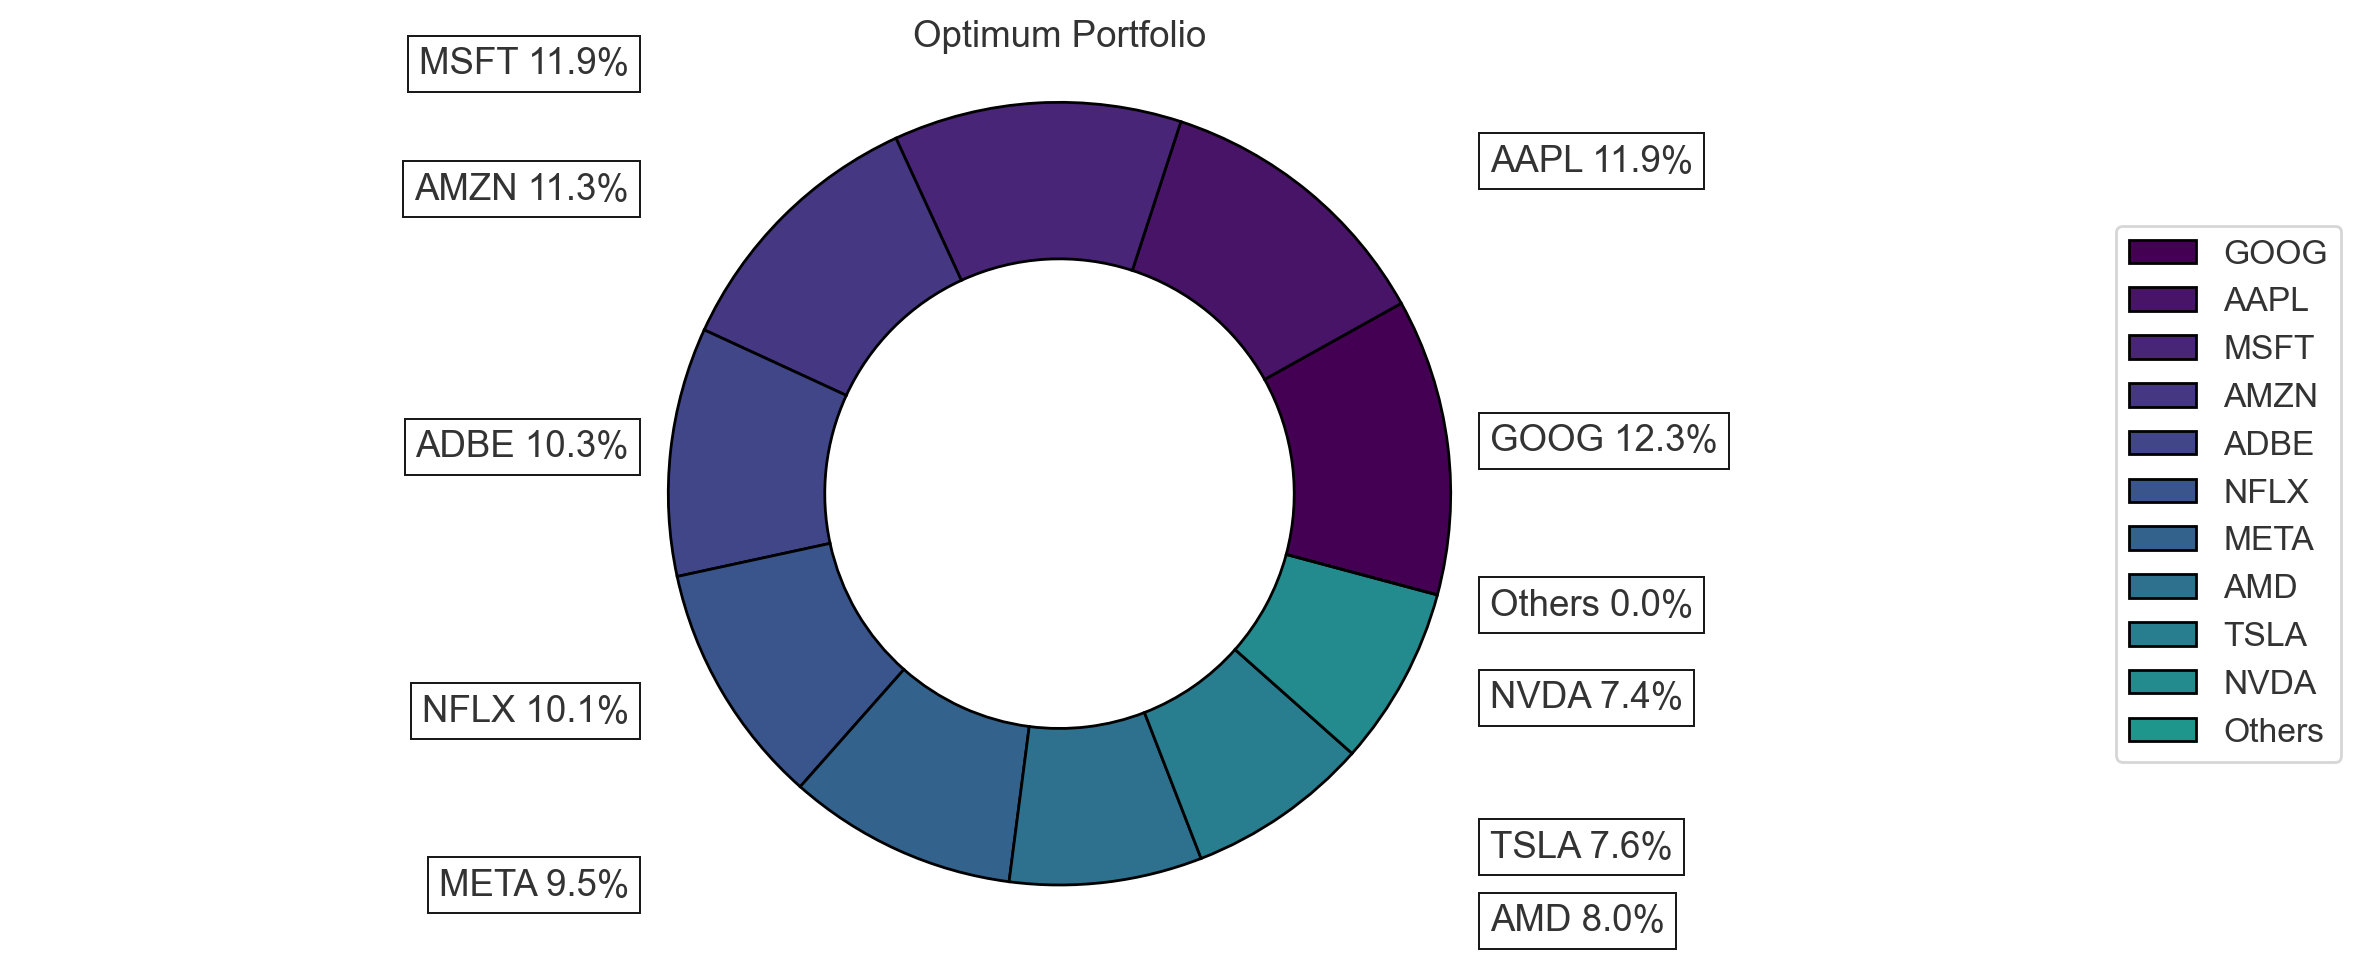

In [23]:
ax=rp.plot_pie(w=w_rp, title="Optimum Portfolio", cmap='viridis', height=5, width=12, ax=None)
plt.show()

In [24]:
points = 50 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head())

AAPL    ADBE     AMD     AMZN     GOOG    META     MSFT    NFLX    NVDA   
0 24.9310% 0.0000% 0.0000% 13.1504% 29.8392% 0.0000% 26.1262% 5.9532% 0.0000%  \
1 39.9938% 0.0000% 0.0000%  0.2464% 25.7774% 0.0000% 26.0327% 2.9829% 0.0000%   
2 44.2741% 0.0000% 0.0000%  0.0000% 22.6345% 0.0000% 23.6971% 0.1499% 0.0000%   
3 46.9454% 0.0000% 0.0000%  0.0000% 19.2119% 0.0000% 20.4669% 0.0000% 1.1453%   
4 48.2569% 0.0000% 0.0000%  0.0000% 16.7861% 0.0000% 17.0844% 0.0000% 4.0868%   

      TSLA  
0  0.0000%  
1  4.9669%  
2  9.2444%  
3 12.2306%  
4 13.7858%

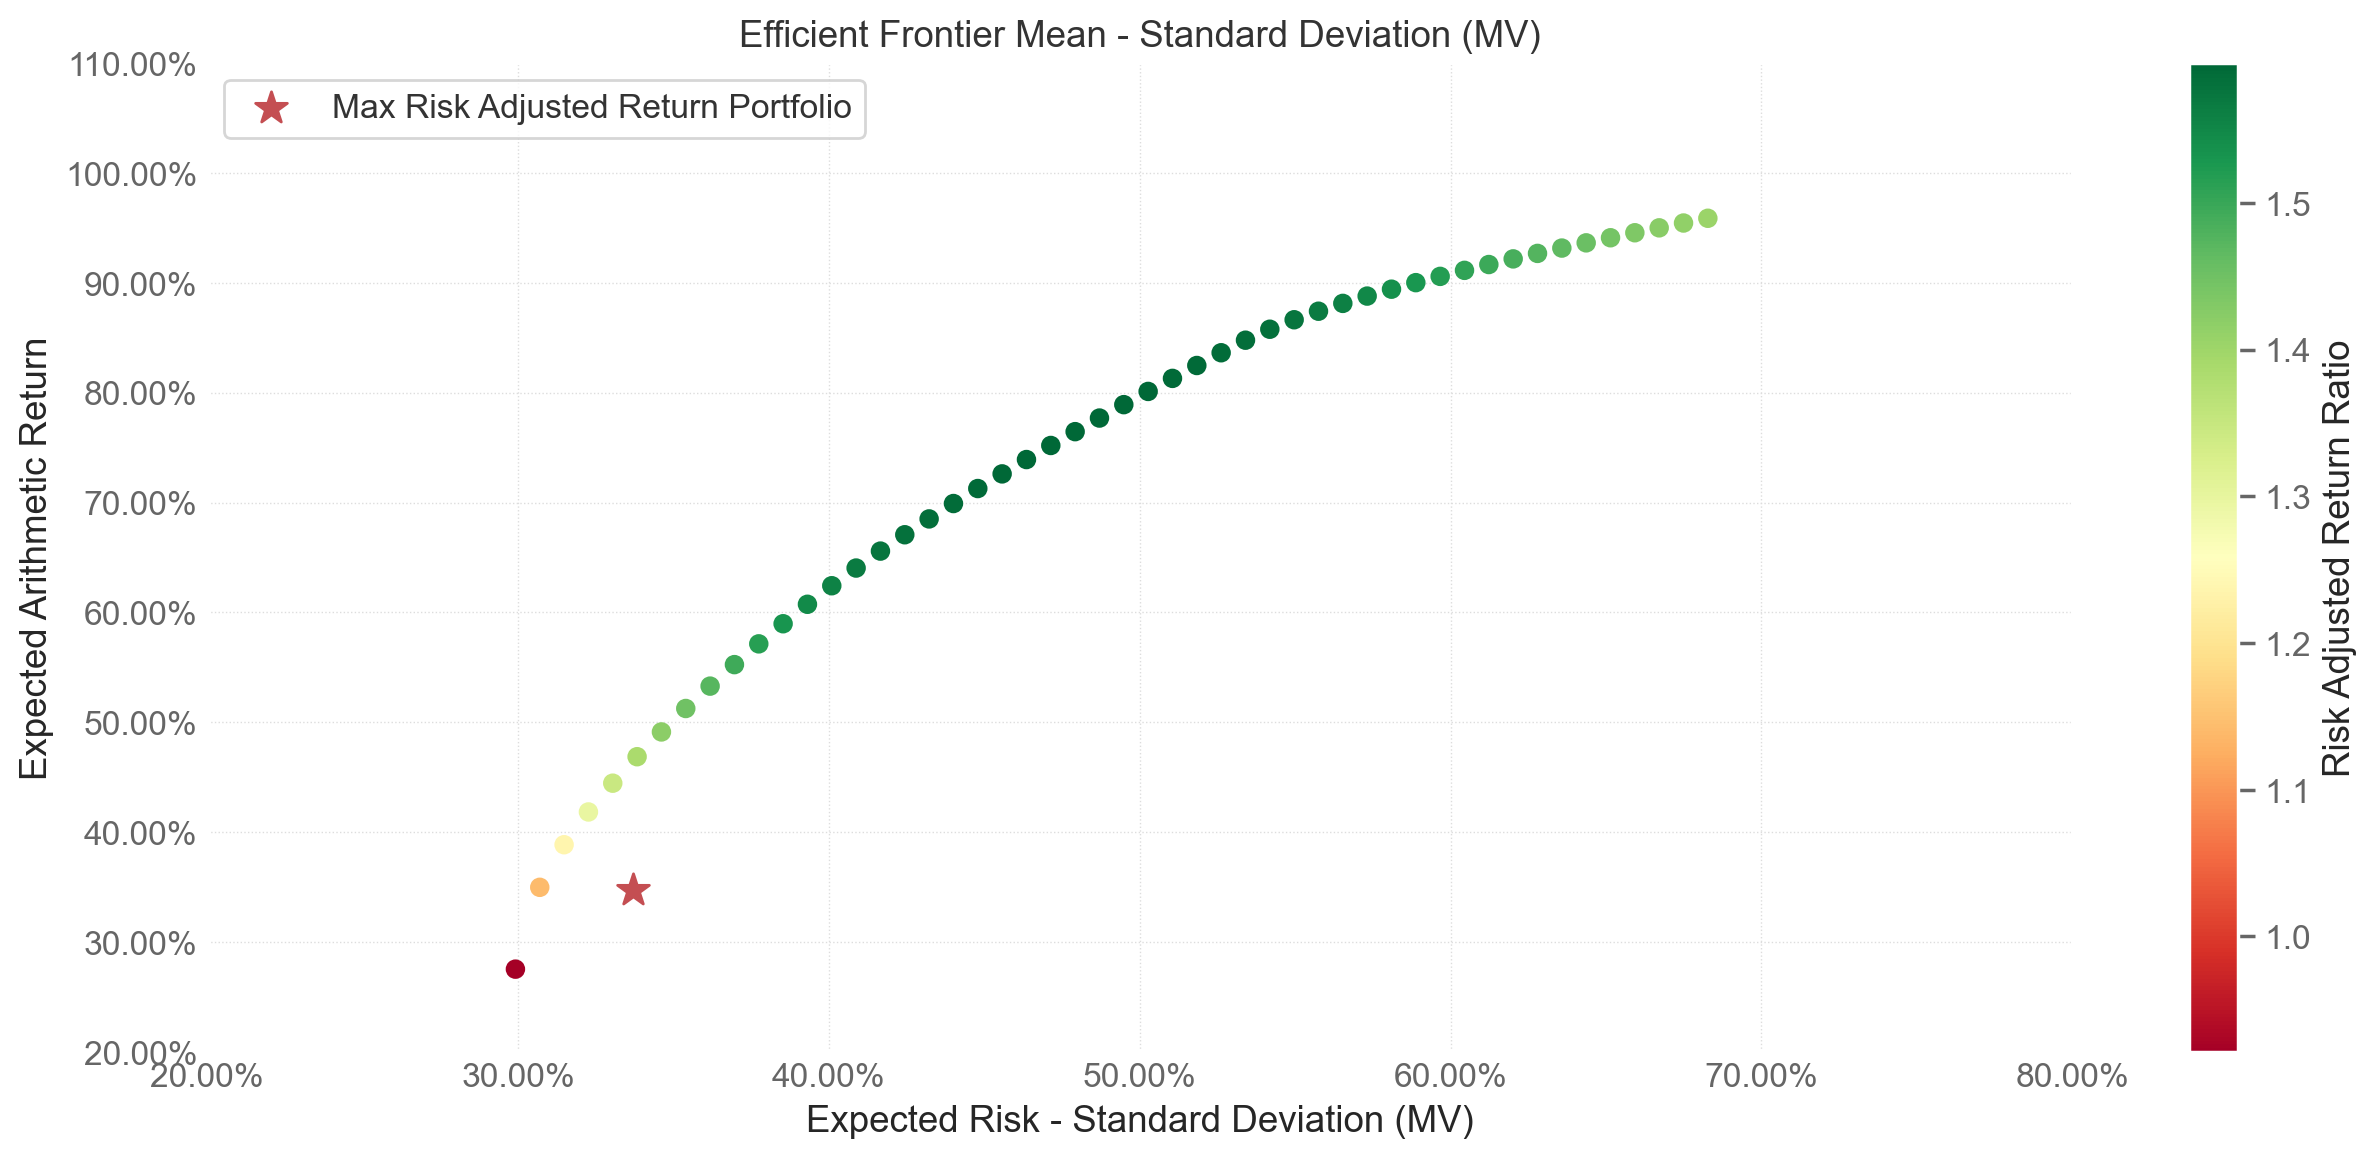

In [25]:
# Plotting the efficient frontier

label = 'Max Risk Adjusted Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='RdYlGn', w=w_rp, label=label,
                      marker='*', s=12, c='r', height=6, width=13, ax=None)

In [26]:
frontier

0        1        2        3        4        5        6        7    
AAPL 24.9310% 39.9938% 44.2741% 46.9454% 48.2569% 49.4696% 50.6028% 51.6768%  \
ADBE  0.0000%  0.0000%  0.0000%  0.0000%  0.0000%  0.0000%  0.0000%  0.0000%   
AMD   0.0000%  0.0000%  0.0000%  0.0000%  0.0000%  0.0000%  0.0000%  0.0000%   
AMZN 13.1504%  0.2464%  0.0000%  0.0000%  0.0000%  0.0000%  0.0000%  0.0000%   
GOOG 29.8392% 25.7774% 22.6345% 19.2119% 16.7861% 14.5562% 12.4702% 10.4960%   
META  0.0000%  0.0000%  0.0000%  0.0000%  0.0000%  0.0000%  0.0000%  0.0000%   
MSFT 26.1262% 26.0327% 23.6971% 20.4669% 17.0844% 13.9657% 11.0488%  8.2872%   
NFLX  5.9532%  2.9829%  0.1499%  0.0000%  0.0000%  0.0000%  0.0000%  0.0000%   
NVDA  0.0000%  0.0000%  0.0000%  1.1453%  4.0868%  6.7905%  9.3209% 11.7153%   
TSLA  0.0000%  4.9669%  9.2444% 12.2306% 13.7858% 15.2180% 16.5573% 17.8247%   

           8        9   ...       40       41       42       43       44   
AAPL 52.6993% 53.6893%  ...  0.0000%  0.0000%  0.0000%  0.0000%  0.0000%  \
ADBE  0.0000%  0.0000%  ...  0.0000%  0.0000%  0.0000%  0.0000%  0.0000%   
AMD   0.0000%  0.0000%  ...  0.0000%  0.0000%  0.0000%  0.0000%  0.0000%   
AMZN  0.0000%  0.0000%  ...  0.0000%  0.0000%  0.0000%  0.0000%  0.0000%   
GOOG  8.6119%  6.8003%  ...  0.0000%  0.0000%  0.0000%  0.0000%  0.0000%   
META  0.0000%  0.0000%  ...  0.0000%  0.0000%  0.0000%  0.0000%  0.0000%   
MSFT  5.6530%  3.1183%  ...  0.0000%  0.0000%  0.0000%  0.0000%  0.0000%   
NFLX  0.0000%  0.0000%  ...  0.0000%  0.0000%  0.0000%  0.0000%  0.0000%   
NVDA 14.0012% 16.1938%  ... 19.1793% 16.8407% 14.5676% 12.3529% 10.1902%   
TSLA 19.0346% 20.1982%  ... 80.8207% 83.1593% 85.4324% 87.6471% 89.8098%   

           45       46       47       48        49  
AAPL  0.0000%  0.0000%  0.0000%  0.0000%   0.0000%  
ADBE  0.0000%  0.0000%  0.0000%  0.0000%   0.0000%  
AMD   0.0000%  0.0000%  0.0000%  0.0000%   0.0000%  
AMZN  0.0000%  0.0000%  0.0000%  0.0000%   0.0000%  
GOOG  0.0000%  0.0000%  0.0000%  0.0000%   0.0000%  
META  0.0000%  0.0000%  0.0000%  0.0000%   0.0000%  
MSFT  0.0000%  0.0000%  0.0000%  0.0000%   0.0000%  
NFLX  0.0000%  0.0000%  0.0000%  0.0000%   0.0000%  
NVDA  8.0744%  6.0011%  3.9664%  1.9670%   0.0000%  
TSLA 91.9256% 93.9989% 96.0336% 98.0330% 100.0000%  

[10 rows x 50 columns]

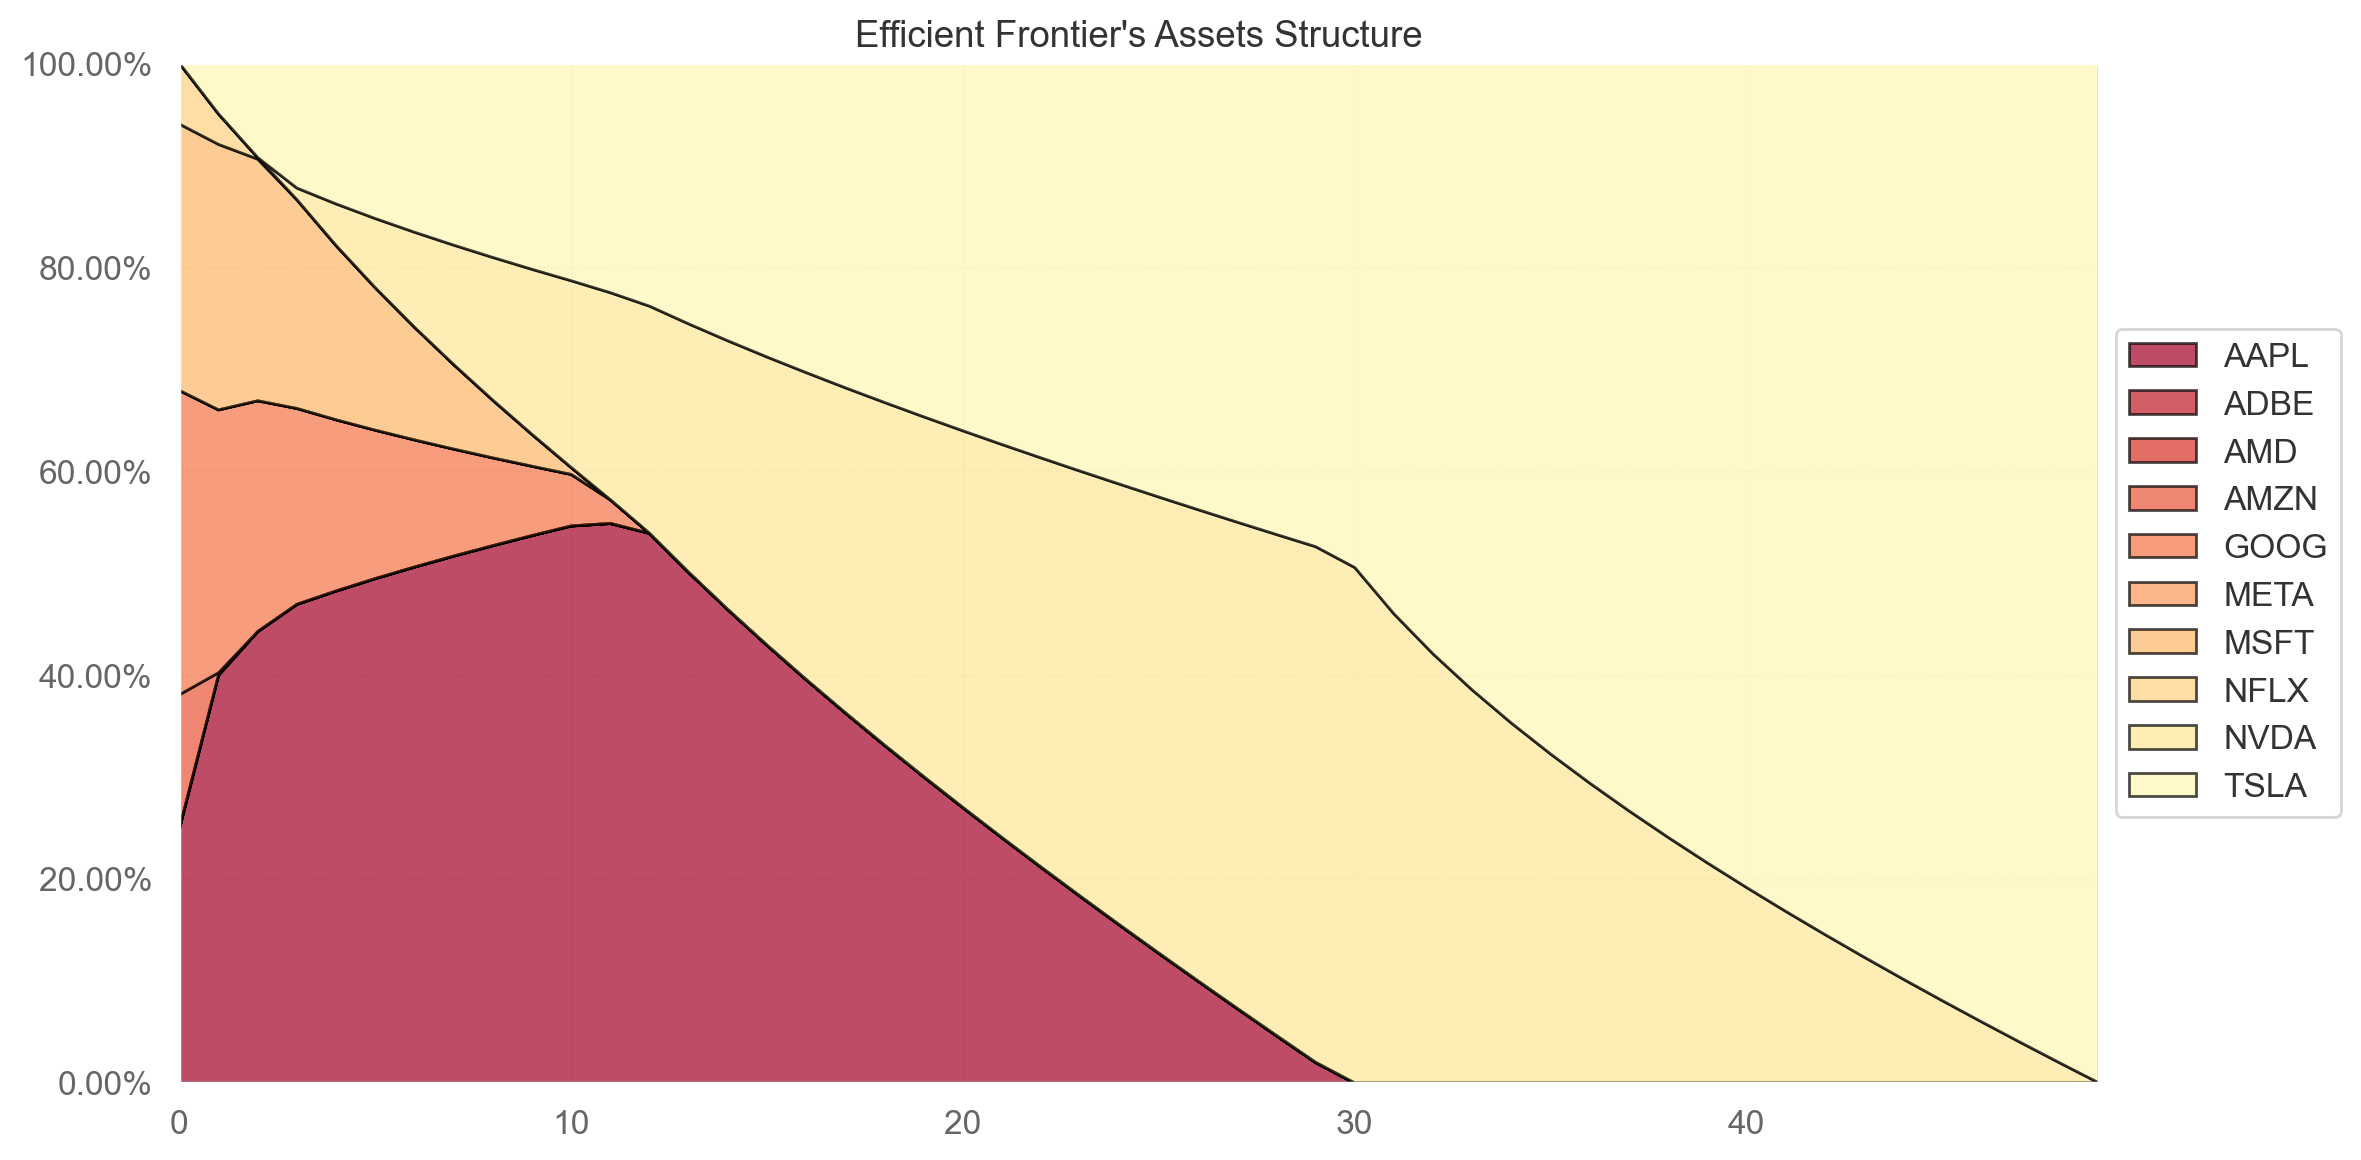

In [27]:
ax = rp.plot_frontier_area(w_frontier=frontier, cmap="RdYlGn", height=6, width=12, ax=None)

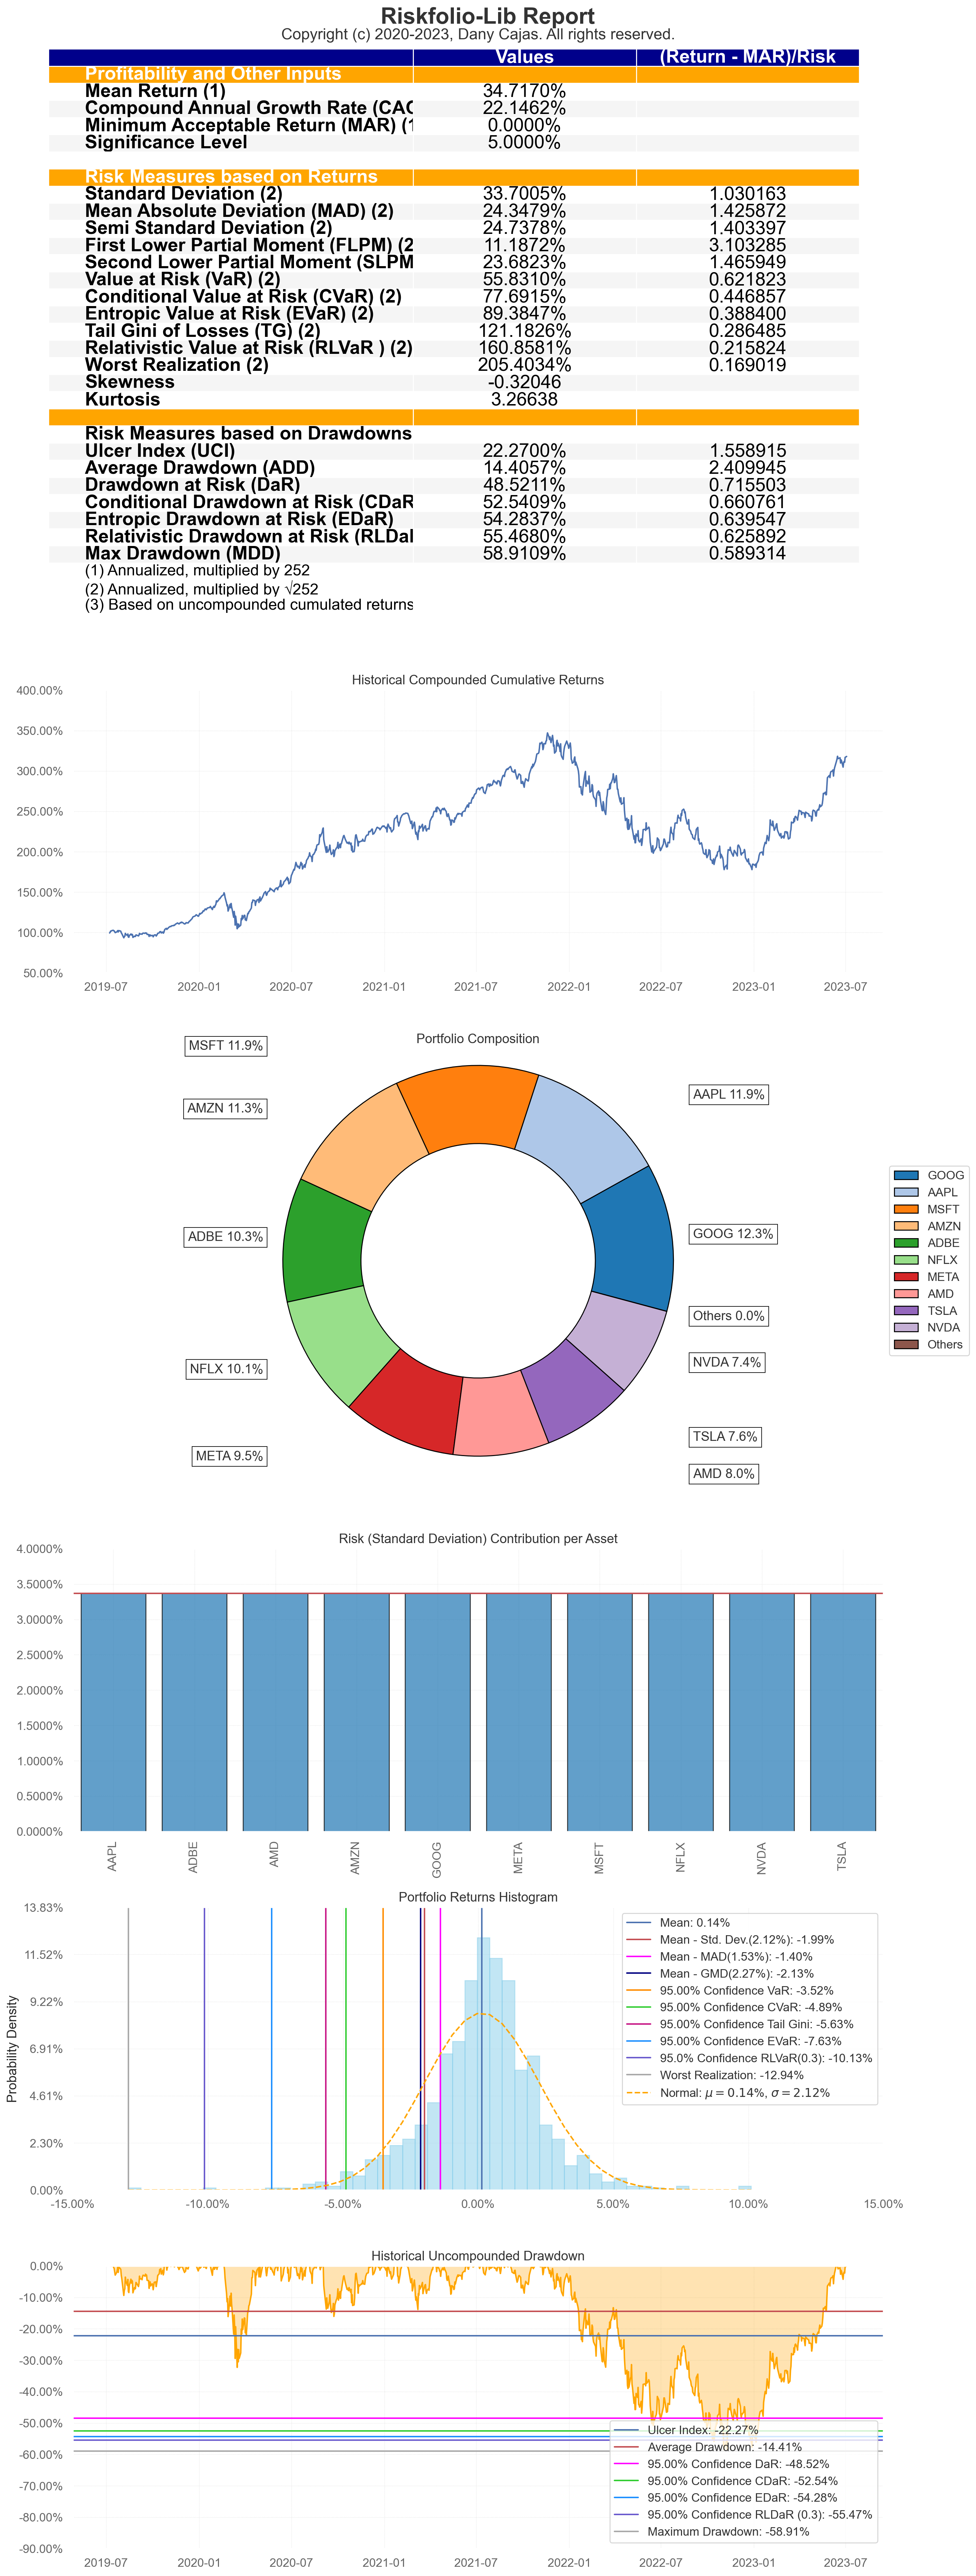

In [28]:
ax=rp.jupyter_report(returns, w_rp, rm=rm, rf=0, alpha=0.05, height=6, width=14, nrow=25)
plt.show()

Calculating the portfolio that maximizes Mean/CVaR ratio 

In [29]:
#rm:Risk measure
rm='CVaR'
alpha=0.05
w_rp=port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
display(w_rp)

weights
AAPL  0.0000%
ADBE  0.0000%
AMD   0.0000%
AMZN  0.0000%
GOOG  0.0000%
META  0.0000%
MSFT  0.0000%
NFLX  0.0000%
NVDA 66.7534%
TSLA 33.2466%

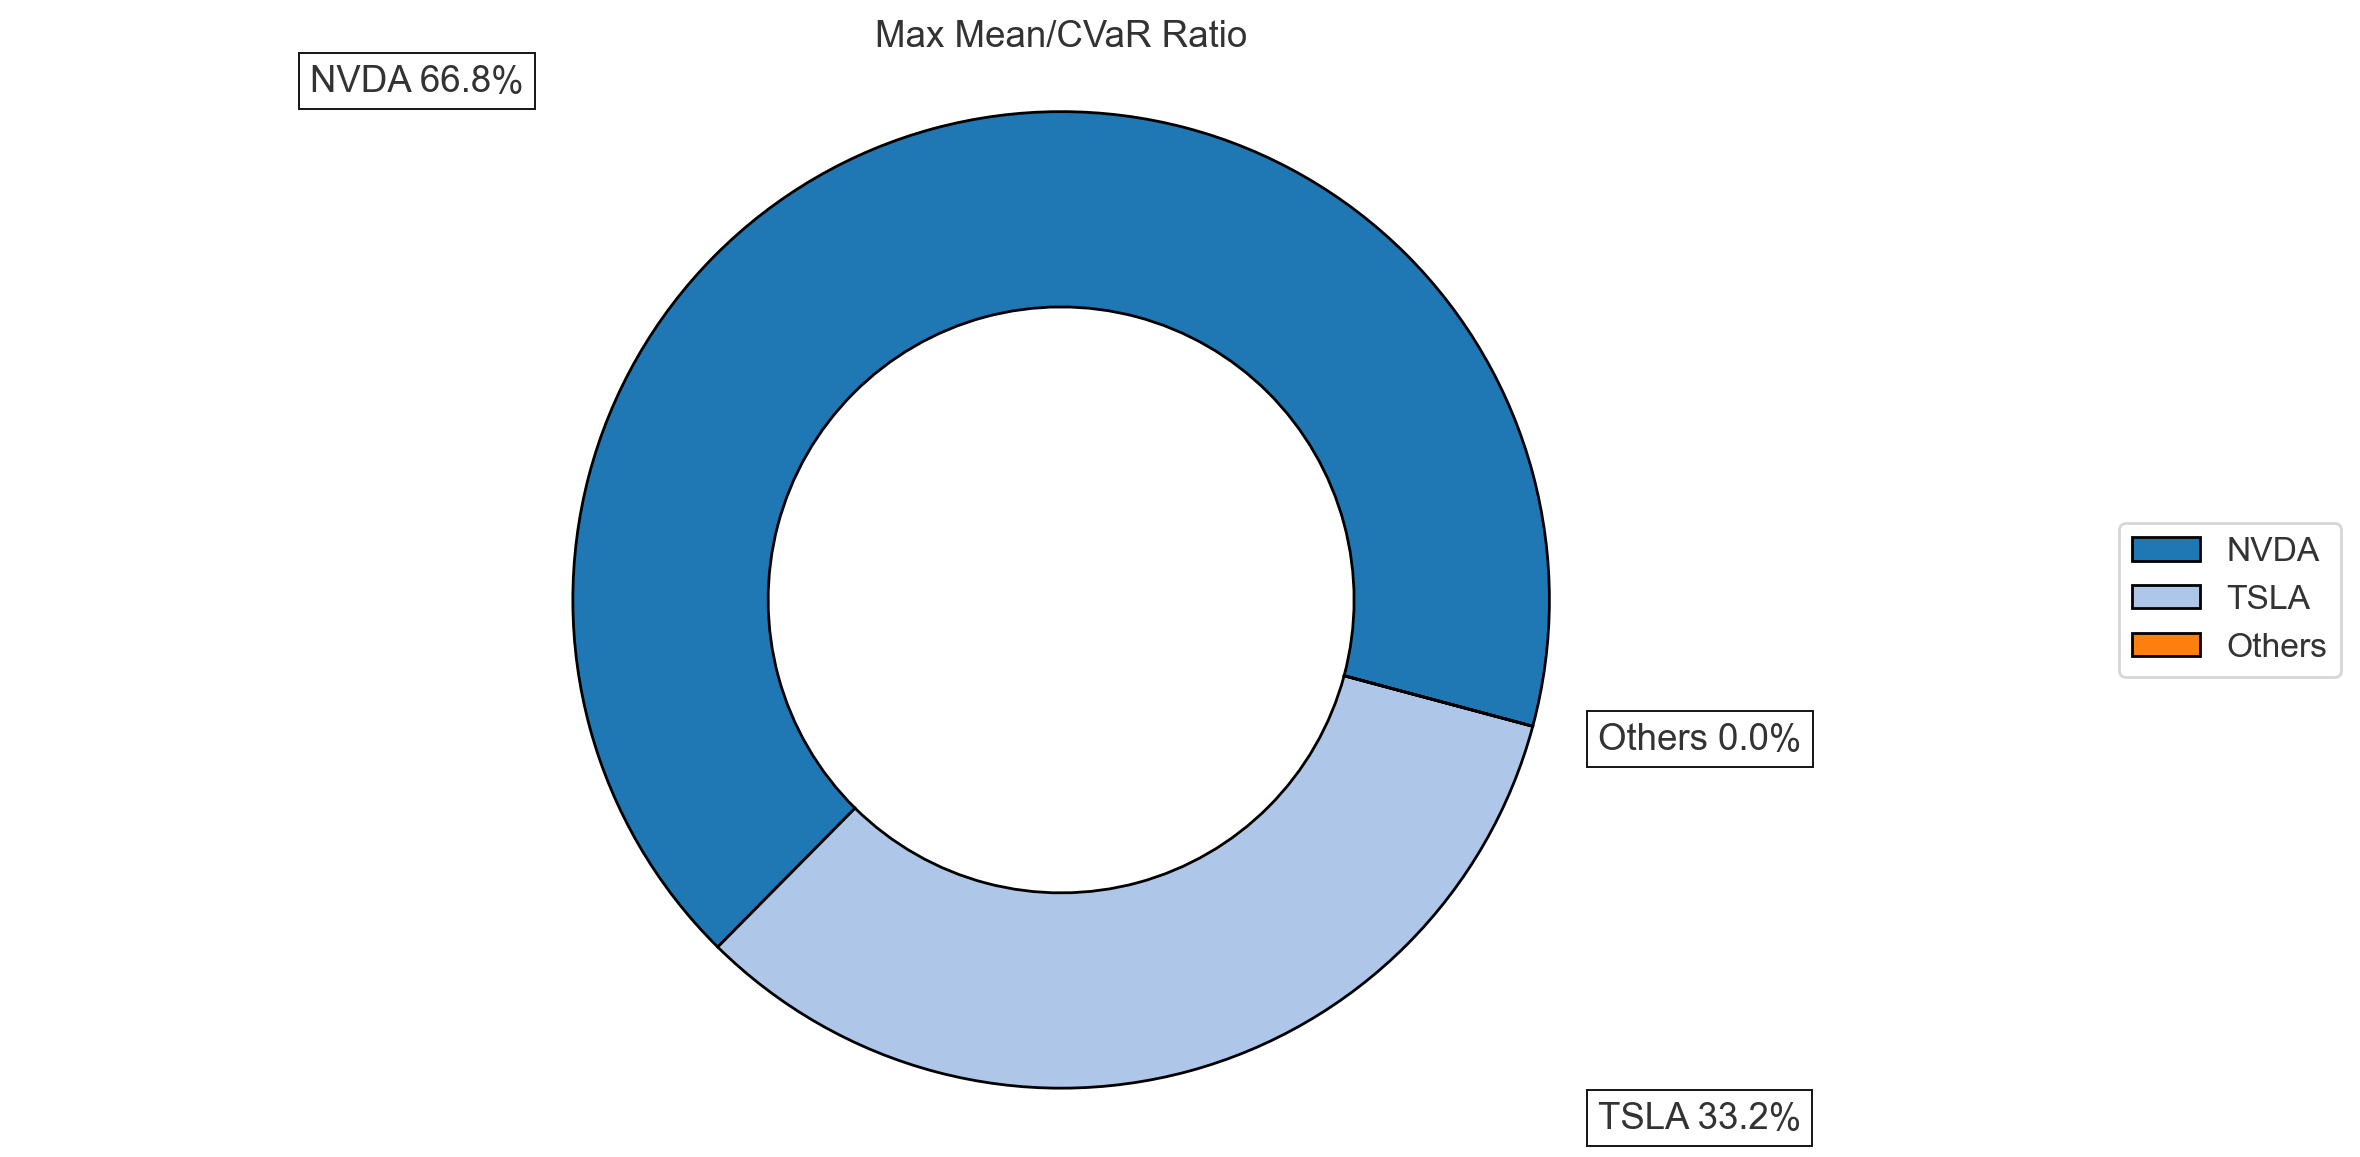

In [30]:
ax=rp.plot_pie(w=w_rp, title='Max Mean/CVaR Ratio', others= 0.05, nrow=25, cmap="tab20", height=6, width=12, ax=None)

In [31]:
#Number of points in the frontier
points=50
frontier=port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)
display(frontier.T.head())

AAPL    ADBE     AMD    AMZN     GOOG    META     MSFT    NFLX    NVDA   
0 19.5921% 0.0000% 0.0000% 9.4229% 30.5737% 0.0000% 37.6092% 2.8021% 0.0000%  \
1 54.5011% 0.0000% 0.0000% 0.0000% 12.1802% 0.0000% 32.7552% 0.0000% 0.0000%   
2 60.1042% 0.0000% 0.0000% 0.0000% 20.1096% 0.0000% 14.9385% 0.0000% 0.0000%   
3 53.7537% 0.0000% 0.0000% 0.0000% 15.9032% 0.0000% 19.9803% 0.0000% 1.2886%   
4 52.2539% 0.0000% 0.0000% 0.0000% 16.8583% 0.0000% 15.5983% 0.0000% 3.4392%   

      TSLA  
0  0.0000%  
1  0.5635%  
2  4.8477%  
3  9.0743%  
4 11.8503%

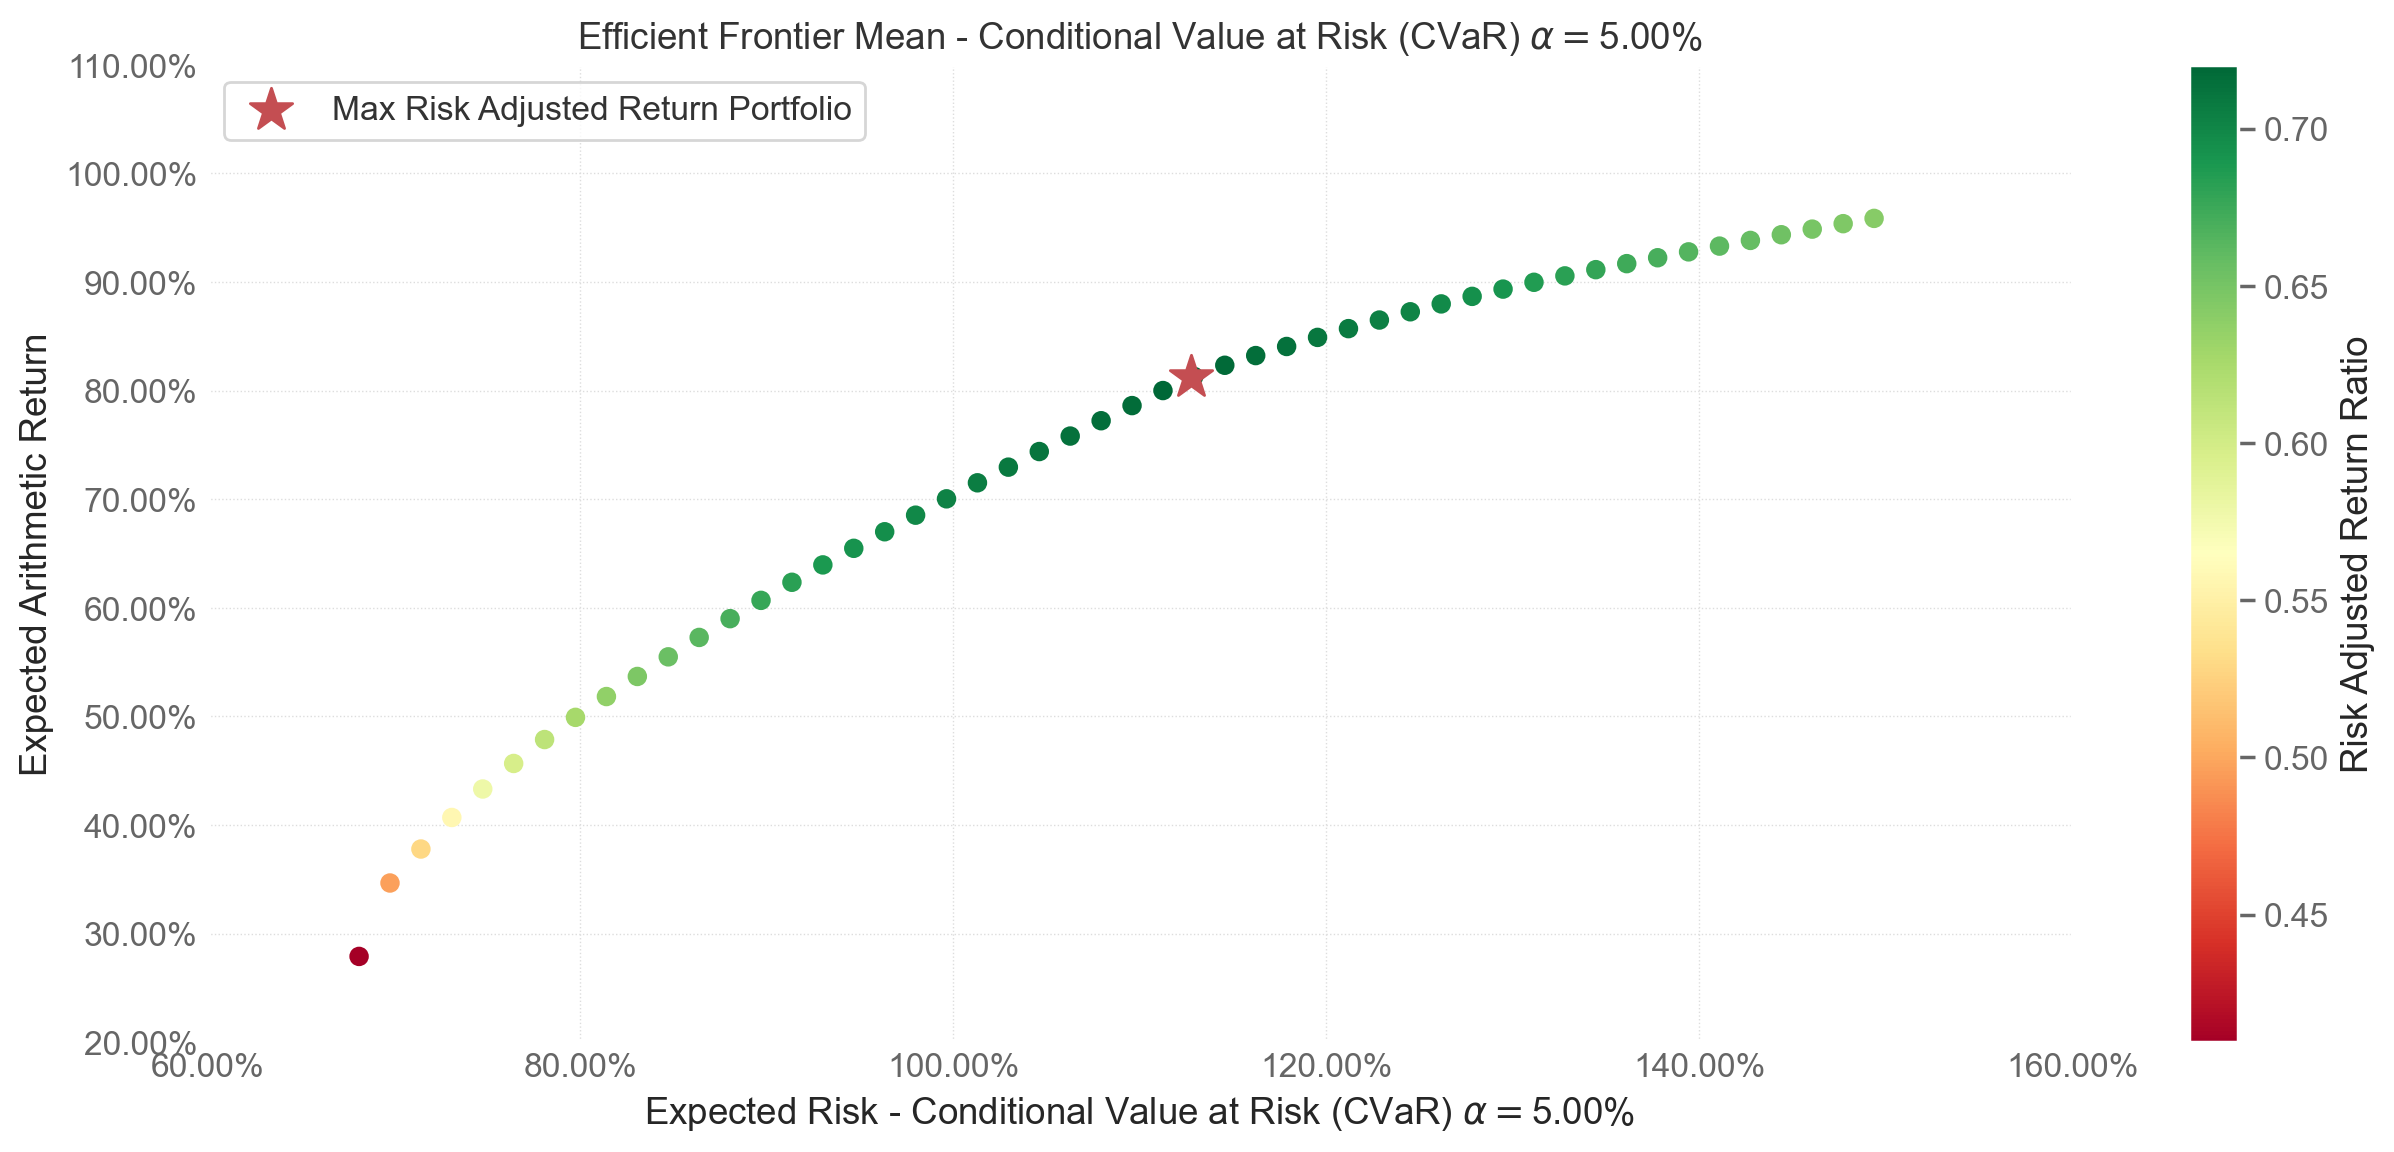

In [32]:
#Plotting frontier
label='Max Risk Adjusted Return Portfolio'
ax=rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm, rf=rf, alpha=alpha, cmap='RdYlGn', w=w_rp, label=label, marker='*', s=16, c='r', height=6, width=13, ax=None)

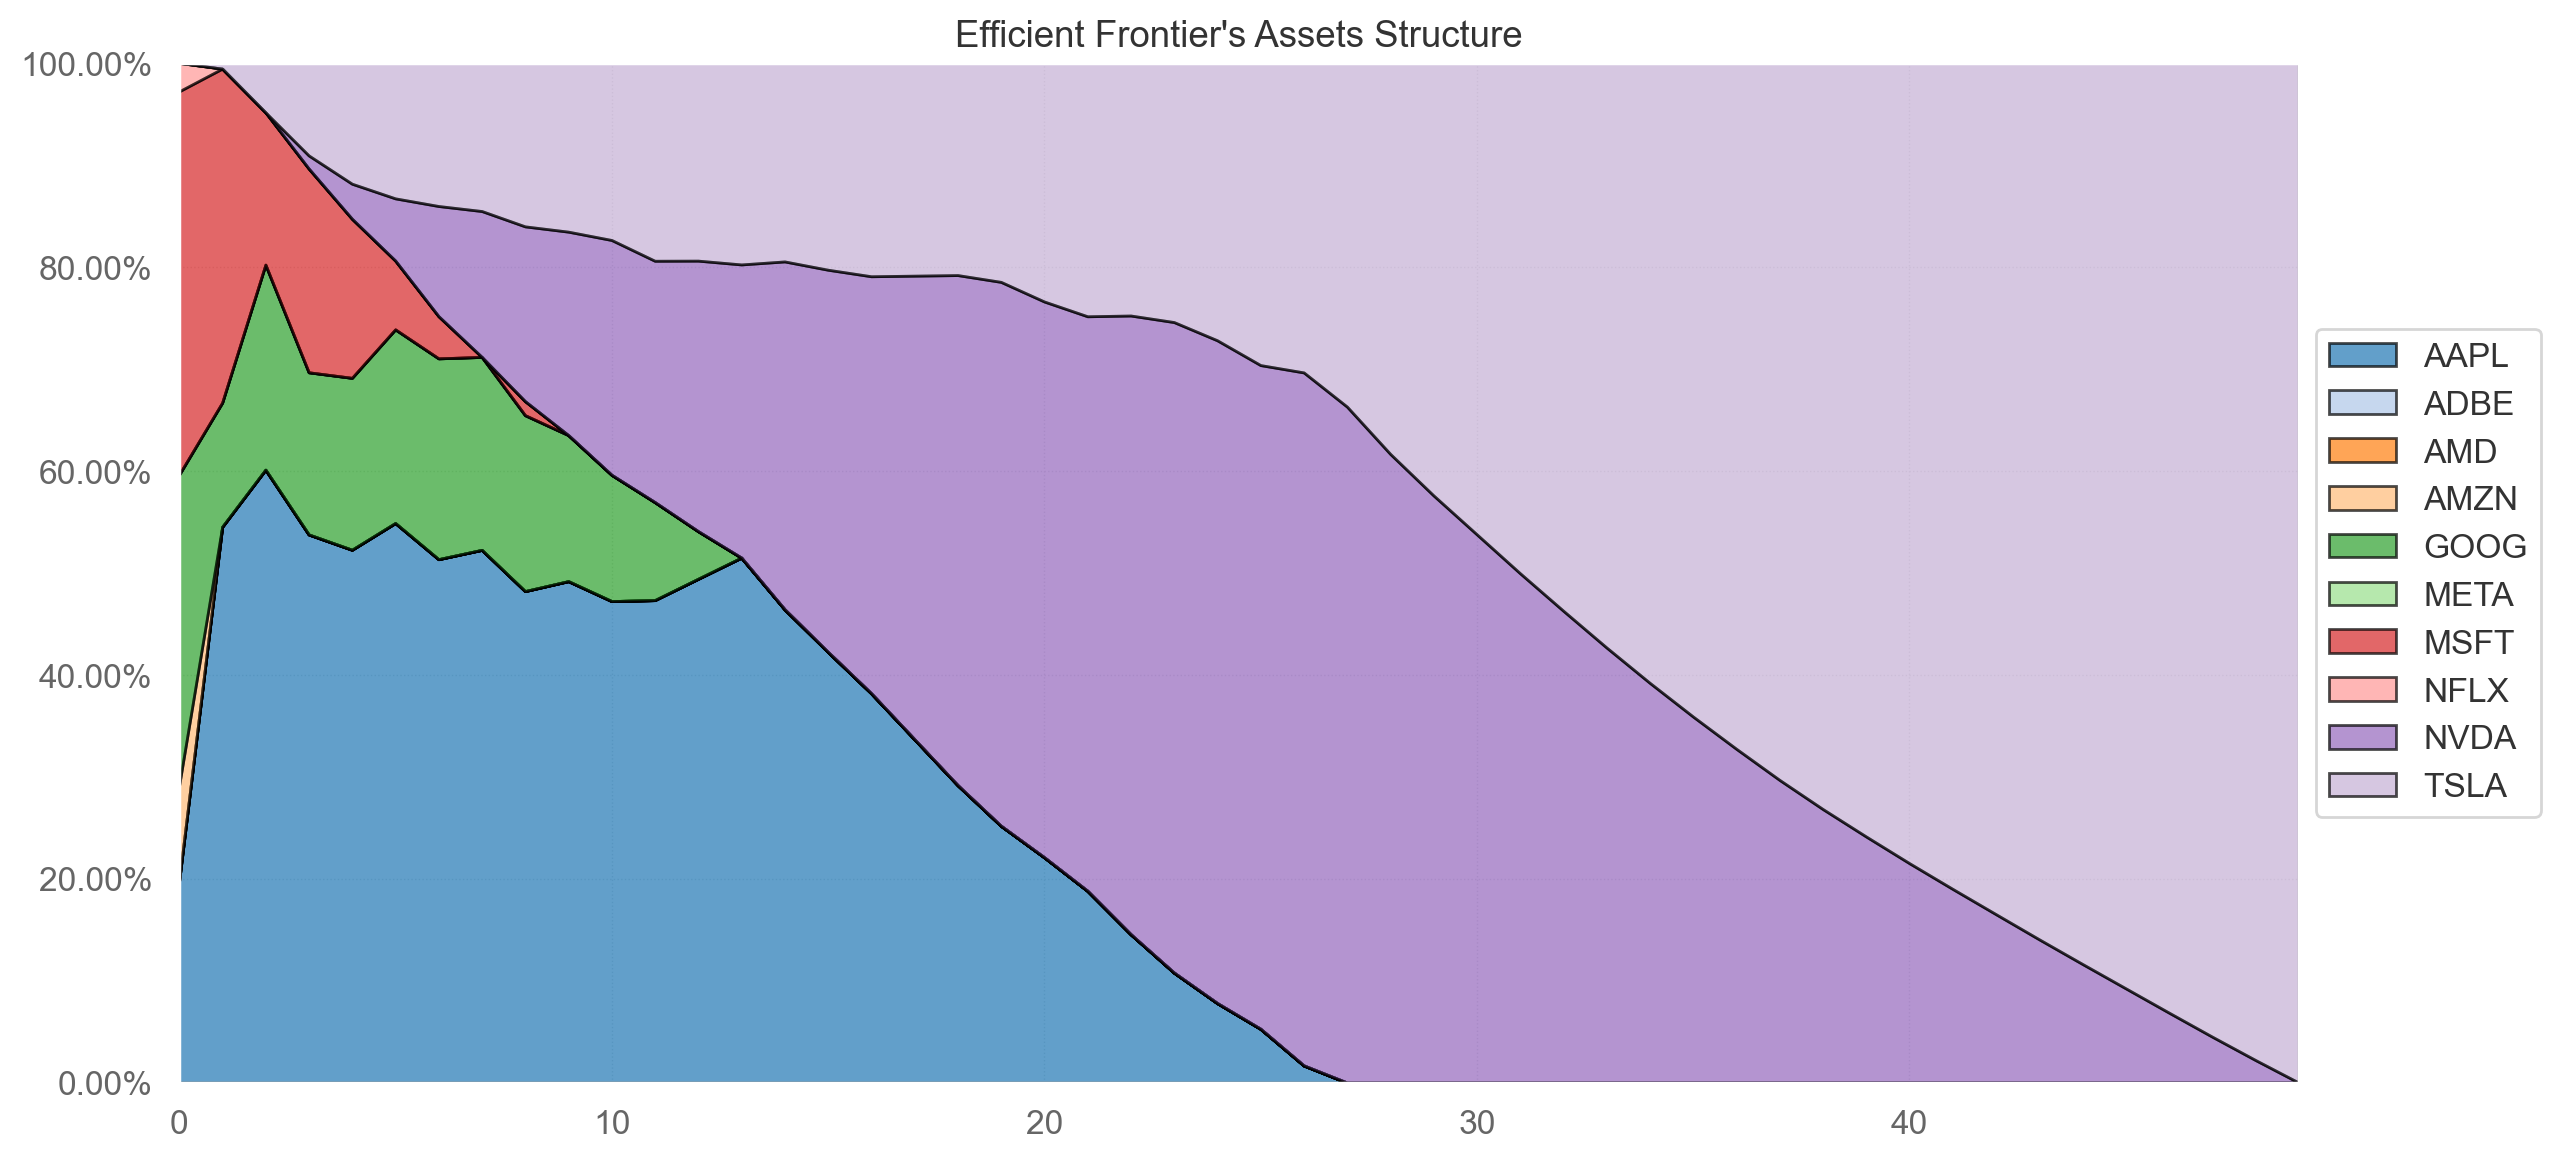

In [33]:
#plot Efficient Frontier Composition
ax=rp.plot_frontier_area(w_frontier=frontier, cmap='tab20', height=6, width=13, ax=None)